In [3]:
from sklearn import feature_selection
import numpy as np
import pandas as pd
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format

def mutual_information_analysis():
    pass
    
# columns of results dataframe
df=df.dropna()
bool_array=df.isnull().values
for i in range(len(bool_array)):
    if True in bool_array[i]:
        display(df.loc[i:i+2,:])
nan_values = df.isna()
nan_columns = nan_values.any()
columns_with_nan = df.columns[nan_columns].tolist()
#print(columns_with_nan)


df['sqrt number_of_comparisons'] = np.sqrt(df['number_of_comparisons'])
columns=['length of time series', 'number of time series compared',
       'incidence mean', 'incidence std', 'expected noise:event ratio',
       'max lag', 'number of populations',
       'individuals within populations similar',
       'individuals across populations similar', 'Z score mean (v1_sigma)',
       'Z score std (v1_sigma)', 'Z score mean (v2_sigma)',
       'Z score std (v2_sigma)', 'raw data directory', 'log ratio',
       'number_of_comparisons', 'sqrt number_of_comparisons', 'v1_null_mean', 'v1_null_std', 'v2_null_mean',
       'v2_null_std', 'v1 weighted Z-score', 'v1 p-value',
       'v2 weighted Z-score', 'v2 p-value']

results_columns=['Z score mean (v1_sigma)',
                 'Z score std (v1_sigma)', 
                 'Z score mean (v2_sigma)',
                 'Z score std (v2_sigma)',
                 'v1_null_mean', 'v1_null_std', 'v2_null_mean',
                 'v2_null_std', 'v1 weighted Z-score', 'v1 p-value',
                 'v2 weighted Z-score', 'v2 p-value'
                ]
parameter_columns_dict={'length of time series' : True, 
                        'number of time series compared' : True,
                        'incidence mean' : False,
                        'incidence std' : False,
                        'expected noise:event ratio' : False,
                        'max lag' : True, 
                        'number of populations' : True,
                        'individuals within populations similar' : True,
                        'individuals across populations similar' : True,
                        'log ratio' : False,
                        'number_of_comparisons' : True,
                        'sqrt number_of_comparisons' : True,
                        }
ordered_headings=np.array(list(parameter_columns_dict.keys()))



### only results that mean anything for v2 sigma have individuals within a population drawn from same incidence
df_v2=df[df['individuals within populations similar']==True]
# store index for this heading in order to remove from results later
v2_index=np.where(ordered_headings == ['individuals within populations similar'])[0][0]

# Mutual information analysis
results={}
for col in results_columns:   
    if 'v2' in col:
        y=df_v2[col].to_numpy()
        X=df_v2[ordered_headings].to_numpy()
    else:
        y=df[col].to_numpy()
        X=df[ordered_headings].to_numpy()
    bool_mask=[parameter_columns_dict[key] for key in ordered_headings]
    results[col]=feature_selection.mutual_info_regression(X, y, discrete_features=bool_mask, n_neighbors=3, copy=True, random_state=None)

results_df=pd.DataFrame.from_dict(results,orient='columns')
results_df['feature']=ordered_headings
results_df.set_index('feature',inplace=True,drop=True)


# sort by v1 MI results
results_df=results_df.sort_values(by=['Z score mean (v1_sigma)'],ascending=False)
# remove very low values
MI_cut_off = 0.1
mask= results_df > MI_cut_off
results_df=results_df.where(mask,'<0.1')
# remove meaningless entries for v2 sigma
v2_cols = [col for col in results_columns if 'v2' in col]
for col in v2_cols:
    results_df.loc['individuals within populations similar',col] = 'NA'
    
display(results_df)

# check linear correlation coefficients
new_headings=np.append(ordered_headings,['Z score mean (v1_sigma)','Z score mean (v2_sigma)'])
df=df[new_headings]
df_corr=df.corr()
# cut off for correlations
#m= abs(df_corr) > 0.1
df_corr=df_corr.sort_values(by=['Z score mean (v1_sigma)'])
#masked_df=df_corr.where(m,'<0.1')
display(df_corr[['Z score mean (v1_sigma)','Z score mean (v2_sigma)']])

KeyError: 'Z score std (v1_sigma)'

In [4]:
print(df.columns)


Index(['length of time series', 'number of time series compared',
       'incidence mean', 'incidence std', 'expected noise:event ratio',
       'max lag', 'number of populations',
       'individuals within populations similar',
       'individuals across populations similar', 'log ratio',
       'number_of_comparisons', 'sqrt number_of_comparisons',
       'Z score mean (v1_sigma)', 'Z score mean (v2_sigma)'],
      dtype='object')


Total length of dataframe 3001
Re-calculated mean v1 score is 1.805196906915557 and stored score is 1.805196906915557
v1 sigma gives mean/std across non-matching populations of 0.6334910141899993/0.9242843405075621
Re-calculated mean v1 score is 0.883612674043858 and stored score is 0.8836126740438579
v1 sigma gives mean/std across non-matching populations of 0.011329734495375016/1.134335491532032
Re-calculated mean v1 score is 1.869338490315568 and stored score is 1.869338490315568
v1 sigma gives mean/std across non-matching populations of -0.02563202470399911/1.06543657306009
Re-calculated mean v1 score is 1.9348753082381231 and stored score is 1.9348753082381231
v1 sigma gives mean/std across non-matching populations of 0.465184252950741/1.0087162152783447
Re-calculated mean v1 score is 0.828902533954007 and stored score is 0.8289025339540068
v1 sigma gives mean/std across non-matching populations of 0.16796501554306645/0.9700005740121009
Re-calculated mean v1 score is 1.92428560615

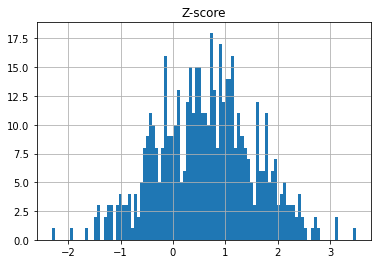

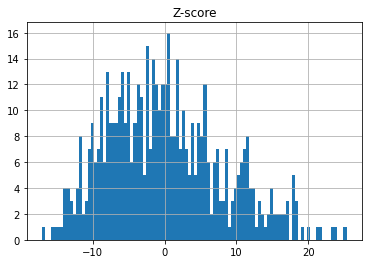

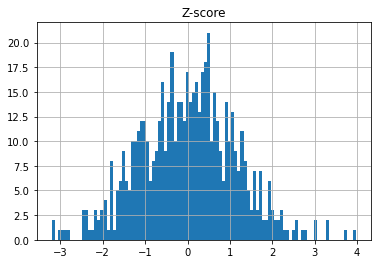

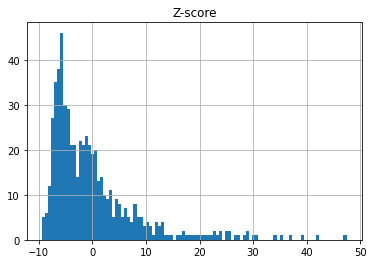

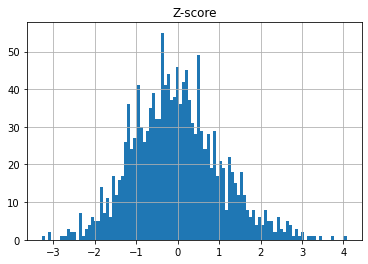

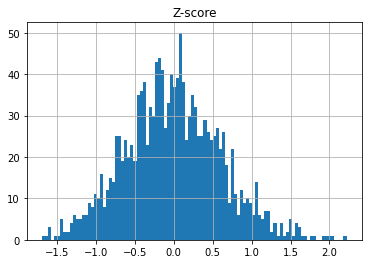

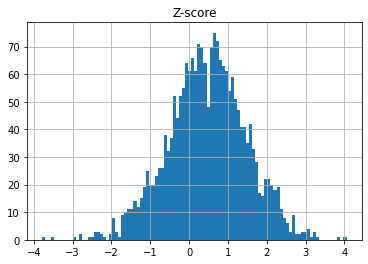

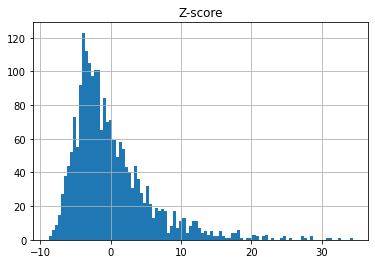

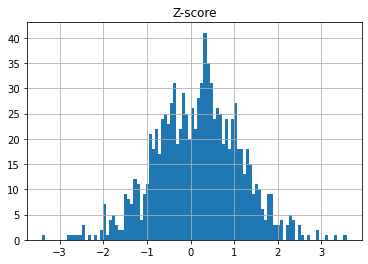

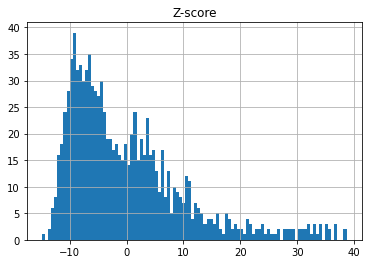

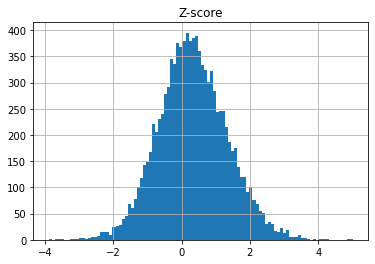

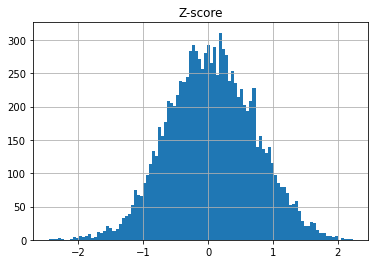

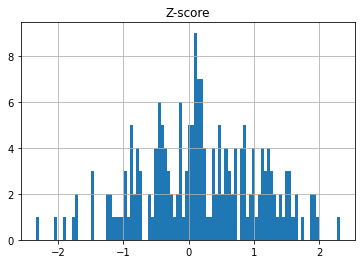

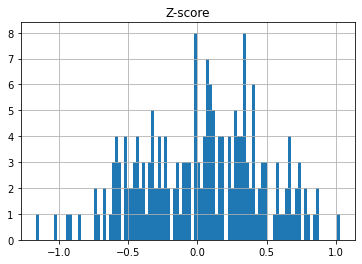

In [1]:
# set up dataframe for analysis below
# analyses the raw data in order to:
# - create a new column showing the number of comparisons on which stored mean p-values and z-scores were based
# - create columns storing mean p-values and z-scores weighted by the number of comparisons

import pandas as pd
import pointwise_correlation as pc
import numpy as np
import testing_and_analysis_functions as analysis_func
from scipy import stats

def calculate_no_of_comparisons(row):
    v1_df,v2_df=analysis_func.load_results_to_dfs(row['raw data directory'])
    # set up dataframes for matching populations
    v1=v1_df[v1_df['name1']==v1_df['name2']]
    v2=v2_df[v2_df['name1']==v2_df['name2']]
    
    # set up null hypothesis mean and std for each sigma measure (based on all null comparisons across populations)
    v2_across_pops=v2_df[v2_df['name1'] != v2_df['name2']]
    v2_null_mean=v2_across_pops['Z-score'].mean()
    v2_null_std=v2_across_pops['Z-score'].std()
    
    v1_across_pops=v1_df[v1_df['name1'] != v1_df['name2']]
    v1_null_mean=v1_across_pops['Z-score'].mean()
    v1_null_std=v1_across_pops['Z-score'].std()

    if np.random.random()<0.003:
        print("Re-calculated mean v1 score is {0} and stored score is {1}".format(v1['Z-score'].mean(), \
                                                                                  row['Z score mean (v1_sigma)']))
        v2_across_pops=v2_df[v2_df['name1'] != v2_df['name2']]
        v1_across_pops=v1_df[v1_df['name1'] != v1_df['name2']]
        print("v1 sigma gives mean/std across non-matching populations of {0}/{1}" \
              .format(v1_across_pops['Z-score'].mean(),v1_across_pops['Z-score'].std()))
        v1_across_pops.hist(column='Z-score',bins=100)
        v2_across_pops.hist(column='Z-score',bins=100)

    assert(len(v1.index)==len(v2.index))
    return pd.Series([len(v1.index),v1_null_mean,v1_null_std,v2_null_mean,v2_null_std])

def calculate_p_values(row):
    x1=row['Z score mean (v1_sigma)']
    mu1=row.v1_null_mean
    sig1=row.v1_null_std
    x2=row['Z score mean (v2_sigma)']
    mu2=row.v2_null_mean
    sig2=row.v2_null_std
    n=row.number_of_comparisons
    Z1 = np.sqrt(n)*(x1-mu1)/sig1
    Z2 = np.sqrt(n)*(x2-mu2)/sig2
    return pd.Series([Z1,stats.norm.cdf(Z1),Z2,stats.norm.cdf(Z2)])



df=pd.read_csv("{0}".format(pc.INDEX_FILE),index_col=0)
print("Total length of dataframe {0}".format(len(df.index)))

# create column for log of noise ratio
df['log ratio']=df['expected noise:event ratio'].apply(lambda x: np.log(x))
df[['number_of_comparisons','v1_null_mean','v1_null_std','v2_null_mean','v2_null_std']] = df.apply(lambda x: calculate_no_of_comparisons(x),axis=1)

# create columns of comparable Z-scores with corresponding columns for
# p-values for v1 and v2 mean z-scores based on the number of comparisons represented by each mean Z-score
df[['v1 weighted Z-score','v1 p-value','v2 weighted Z-score','v2 p-value']] \
    =df.apply(lambda x: calculate_p_values(x),axis=1)
#df[]=df.apply(lambda x: stats.norm.cdf(x['v1 weighted Z-score']),axis=1)
#df[]=df.apply(lambda x: x['Z score mean (v2_sigma)']*np.sqrt(x.number_of_comparisons),axis=1)
#df[]=df.apply(lambda x: stats.norm.cdf(x['v2 weighted Z-score']),axis=1)

Scores using version 1 on test data are 0.6423487009252342
Parameters are [[-0.61920465]]
Scores using version 2 on test data are 0.27794315548559423
Parameters are [[-0.14711455]]


,length of time series,number of time series compared,incidence mean,incidence std,expected noise:event ratio,max lag,number of populations,individuals within populations similar,individuals across populations similar,Z score mean (v1_sigma),...,v1_null_mean,v1_null_std,v2_null_mean,v2_null_std,v1 weighted Z-score,v1 p-value,v2 weighted Z-score,v2 p-value,Sqrt number_of_comparisons,sqrt number_of_comparisons
0,2700,15,0.29,0.07,0.66,55,3,False,True,2.73,...,0.91,0.66,0.11,7.07,15.14,1.00,-0.04,0.48,5.48,5.48
1,1128,41,0.16,0.08,0.59,29,6,False,False,1.66,...,0.47,0.88,0.09,5.26,16.45,1.00,0.00,0.50,12.04,12.04
2,3610,25,0.19,0.05,1.59,54,3,True,False,3.24,...,-0.19,1.54,-0.04,0.67,22.96,1.00,7.56,1.00,10.30,10.30
3,2254,26,0.22,0.07,1.46,54,4,False,False,1.26,...,0.17,0.98,0.02,6.86,9.72,1.00,-0.12,0.45,8.72,8.72
4,4079,30,0.23,0.04,1.53,17,7,True,False,0.84,...,-0.23,0.89,-0.03,0.66,10.10,1.00,1.66,0.95,8.37,8.37
5,4175,55,0.04,0.02,10.07,58,8,True,False,0.42,...,0.05,0.97,0.02,0.90,5.00,1.00,2.33,0.99,13.23,13.23
6,4963,76,0.20,0.01,0.74,36,4,True,True,2.30,...,0.35,0.96,0.04,0.72,53.42,1.00,8.84,1.00,26.15,26.15
7,2584,60,0.22,0.07,2.34,51,8,False,False,0.95,...,0.13,0.95,0.02,7.32,13.78,1.00,-0.11,0.46,15.94,15.94
8,3078,32,0.14,0.05,1.99,20,5,True,False,2.87,...,0.16,0.75,0.03,0.57,36.17,1.00,9.05,1.00,10.00,10.00
9,3868,28,0.16,0.01,0.24,11,5,True,False,2.62,...,-0.06,0.89,-0.01,0.38,24.65,1.00,8.38,1.00,8.19,8.19


V1 low significant : 3
V2 low significant : 0


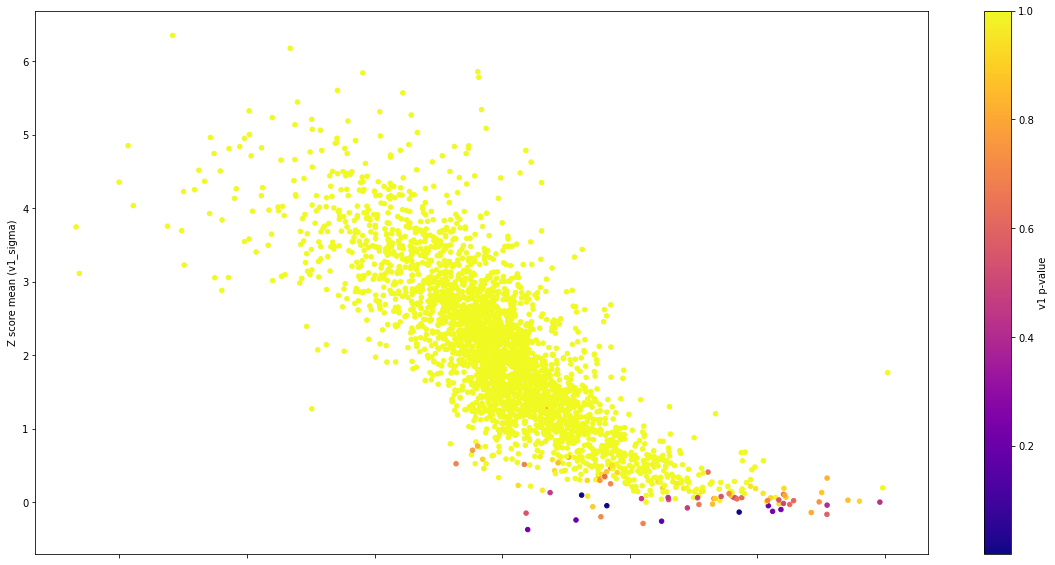

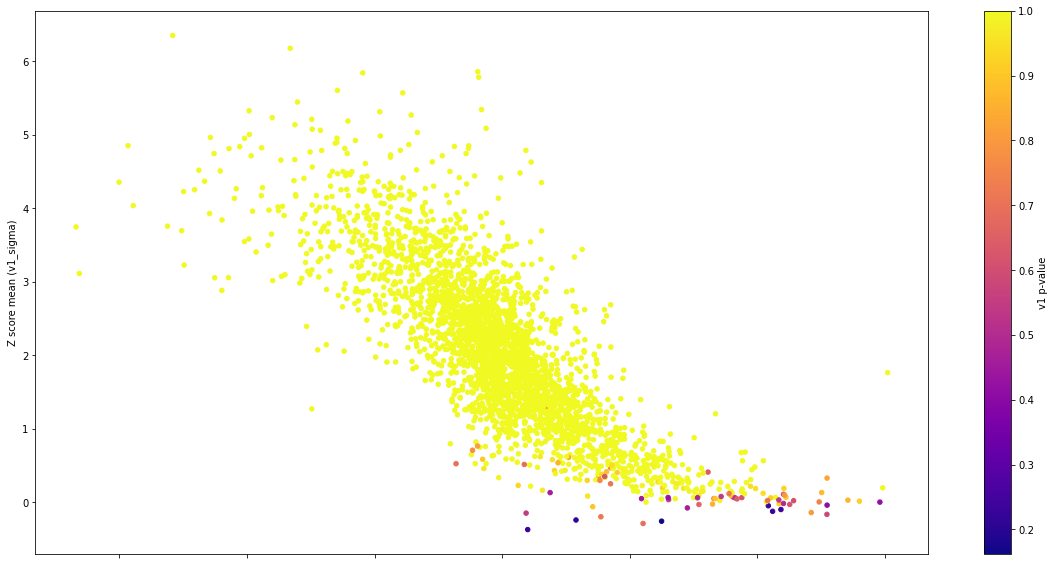

,Z score mean (v1_sigma),Z score mean (v2_sigma)
length of time series,0.20,
number of time series compared,,
incidence mean,-0.16,-0.24
incidence std,-0.14,-0.42
expected noise:event ratio,-0.26,-0.13
max lag,,
number of populations,,
Z score mean (v1_sigma),1.00,0.66
Z score std (v1_sigma),0.16,
Z score mean (v2_sigma),0.66,1.00


In [46]:
# analyse the index dataframe for correlations between variables and z-scores


import pointwise_correlation as pc
import pandas as pd
import numpy as np
import Louvain
import testing_and_analysis_functions as analysis_func
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize']=[20,10]




# plot scattergraphs of v1 and v2 mean Z-scores against grouped noise ratio and log(noise ratio)
"""
# group dataframe by noise ratio and take means of every parameter within these groups
df_by_noise_ratio_groups=df.groupby('expected noise:event ratio')
df_by_noise_ratio=df_by_noise_ratio_groups.mean()
#print(df_by_noise_ratio_groups.size())
#df_by_noise_ratio.scatter('log ratio',10)
#display(df_by_noise_ratio)
df_by_noise_ratio['expected noise:event ratio']=df_by_noise_ratio.index
for i in [8,10]:
    df_by_noise_ratio.plot.scatter('log ratio',i)#'Z score mean (v1_sigma)')
    df_by_noise_ratio.plot.scatter('expected noise:event ratio',i)#'Z score mean (v1_sigma)')
#df.plot.scatter('log ratio',10)
"""

# linear regression on log ratio - what about using adjusted z-values instead?

# decide whether to use Z-scores that have been weighted by the number of comparisons made
weighted=False
if weighted:
    df.dropna(inplace=True)
    v1_Z_score_col = 'v1 weighted Z-score'
    v2_Z_score_col = 'v2 weighted Z-score'
else:
    v1_Z_score_col = 'Z score mean (v1_sigma)'
    v2_Z_score_col = 'Z score mean (v2_sigma)'
    
df_train=df.tail(2990)
df_test=df.tail(2990)
# version 1 linear regression
lin_reg=LinearRegression().fit(np.array(df_train['log ratio']).reshape(len(df_train.index),1), \
                               np.array(df_train[v1_Z_score_col]).reshape(len(df_train.index),1))
score_v1 = lin_reg.score(np.array(df_test['log ratio']).reshape(len(df_test.index),1), \
                      np.array(df_test[v1_Z_score_col]).reshape(len(df_test.index),1))
print("Scores using version 1 on test data are {0}".format(score_v1))
print("Parameters are {0}".format(lin_reg.coef_))

# version 2 linear regression
lin_reg=LinearRegression().fit(np.array(df_train['log ratio']).reshape(len(df_train.index),1), \
                               np.array(df_train[v2_Z_score_col]).reshape(len(df_train.index),1))
score_v2 = lin_reg.score(np.array(df_test['log ratio']).reshape(len(df_test.index),1), \
                      np.array(df_test[v2_Z_score_col]).reshape(len(df_test.index),1))

print("Scores using version 2 on test data are {0}".format(score_v2))
print("Parameters are {0}".format(lin_reg.coef_))


# plot scattergraphs of v1 and v2 mean Z-scores against noise and log(noise) without grouping
display(df.head(10))

# remove insignificant p-values
significance_level=0.01
v1_not_significant_index = df[ df['v1 p-value'] < significance_level].index
print("V1 low significant : {0}".format(len(v1_not_significant_index)))
#v1_too_significant_index=df[ df['v1 p-value'] > 100].index
#print("V1 too significant : {0}".format(len(v1_too_significant_index)))
v2_not_significant_index = df[ df['v2 p-value'] < significance_level].index
print("V2 low significant : {0}".format(len(v2_not_significant_index)))
v1_df=df.drop(list(set(v1_not_significant_index)))#.union(set(v1_too_significant_index))))
v2_df=df.drop(v2_not_significant_index)
v2_df=v2_df[v2_df['individuals within populations similar'] == True]

df.plot.scatter(x='log ratio', y = v1_Z_score_col, c='v1 p-value', colormap='plasma')
v1_df.plot.scatter(x='log ratio', y = v1_Z_score_col, c='v1 p-value', colormap='plasma')
#df.plot.scatter(x='log ratio', y=11, c='v2 p-value', colormap='plasma')
#v2_df.plot.scatter(x='log ratio', y=11, c='v2 p-value', colormap='plasma')






"""
for i in [9]:
    df.plot.scatter(x='log ratio', y=i,c='v1 p-value',colormap='plasma')
    v1_df.plot.scatter('log ratio', i)
    #df.plot.scatter('expected noise:event ratio', i)
    #v1_df.plot.scatter('expected noi')
"""

plt.show()

# look for correlations 
df_clean=df.replace([True,False],[1,0])
#display(df_clean.tail(5))
df_clean.drop(['raw data directory'],axis=1,inplace=True)
df_clean.drop(['individuals within populations similar', 'individuals across populations similar'],axis=1,inplace=True)
df_corr=df_clean.corr()
#display(df_corr.tail(5))

# cut off for correlations
m= abs(df_corr) > 0.1

masked_df=df_corr.where(m,' ')
display(masked_df[['Z score mean (v1_sigma)','Z score mean (v2_sigma)']])
#display(df_corr.where(m,' ')['Z score mean (v1_sigma)','Z score mean (v2 sigma)'])
#from sklearn.metrics import explained_variance_score







In [41]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'ID':['1', '2', '3'], 'col_1': [0, 2, 3], 'col_2':[1, 4, 5]})
mylist = ['a', 'b', 'c', 'd', 'e', 'f']
def get_sublist(sta,end):
    return mylist[sta:end+1]

df['col_3'] = df.apply(lambda x: x.col_2**3, axis=1)
display(df)

,ID,col_1,col_2,col_3
0,1,0,1,1
1,2,2,4,64
2,3,3,5,125


In [51]:
df_train=df.head(3000)
df_test=df.tail(3000)
display(df_train.head(5))
# version 1 linear regression
lin_reg=LinearRegression().fit(list(zip(df_train['log ratio'],df_train['number_of_comparisons'])), \
                               np.array(df_train[v1_Z_score_col]).reshape(len(df_train.index),1))
score_v1 = lin_reg.score(list(zip(df_test['log ratio'],df_test['number_of_comparisons'])), \
                      np.array(df_test[v1_Z_score_col]).reshape(len(df_test.index),1))

print(score_v1)

,length of time series,number of time series compared,incidence mean,incidence std,expected noise:event ratio,max lag,number of populations,individuals within populations similar,individuals across populations similar,Z score mean (v1_sigma),...,log ratio,number_of_comparisons,v1_null_mean,v1_null_std,v2_null_mean,v2_null_std,v1 weighted Z-score,v1 p-value,v2 weighted Z-score,v2 p-value
0,2700,15,0.286,0.069,0.659,55,3,False,True,2.727,...,-0.416,30.0,0.907,0.659,0.108,7.073,15.138,1.0,-0.043,0.483
1,1128,41,0.157,0.078,0.595,29,6,False,False,1.663,...,-0.520,145.0,0.468,0.875,0.086,5.258,16.445,1.0,0.004,0.502
2,3610,25,0.192,0.053,1.592,54,3,True,False,3.236,...,0.465,106.0,-0.188,1.535,-0.038,0.673,22.956,1.0,7.557,1.000
3,2254,26,0.223,0.068,1.457,54,4,False,False,1.262,...,0.377,76.0,0.168,0.981,0.020,6.865,9.718,1.0,-0.118,0.453
4,4079,30,0.235,0.040,1.532,17,7,True,False,0.836,...,0.427,70.0,-0.233,0.885,-0.029,0.657,10.104,1.0,1.657,0.951


0.650307429002724


In [5]:
import numpy as np
X = np.array(list((zip([1,2,3,4],[2,5,6,8]))))
print(X)
print(np.sqrt(X))
y = np.dot(X,[1,3])
print((y))

lin_reg=LinearRegression().fit(X, y)
print(lin_reg.score(X ,y))
print(lin_reg.coef_)

[[1 2]
 [2 5]
 [3 6]
 [4 8]]
[[1.         1.41421356]
 [1.41421356 2.23606798]
 [1.73205081 2.44948974]
 [2.         2.82842712]]
[ 7 17 21 28]


NameError: name 'LinearRegression' is not defined

In [109]:
print([1,2]+[np.inf]+[3,4])

[1, 2, inf, 3, 4]


In [133]:
print(['hi','ny']+['hi'])

['hi', 'ny', 'hi']
